In [1]:
# 랜덤 시드 설정
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# 데이터 불러오기
from tensorflow.keras.datasets import mnist

(X_raw, _), (_, _) = mnist.load_data()

In [3]:
# 변수 설정
n_img = X_raw.shape[0]
epoch = 3000
n_batch = 100

In [4]:
# 데이터 전처리
import numpy as np

X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c
real_1 = np.ones((n_batch, 1))
fake_0 = np.zeros((n_batch, 1))

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU

In [6]:
# 생성자
input_layer1 = Input(shape=(100,))
x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7,7,64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size=(3,3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)
output_layer1 = Conv2D(1, kernel_size=(3,3), 
                       padding='same', 
                       activation='tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                           

In [7]:
# 판별자
input_layer2 = Input(shape=(28, 28, 1))
x2 = Conv2D(64, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size=(3,3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
output_layer2 = Dense(1, activation='sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 activation_3 (Activation)   (None, 28, 28, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0   

In [8]:
# GAN
input_gan = Input(shape=(100,))
output_dis = discriminator(generator(input_gan))
gan = Model(input_gan, output_dis)
gan.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         348161    
                                                                 
 model_1 (Functional)        (None, 1)                 175873    
                                                                 
Total params: 524,034
Trainable params: 341,825
Non-trainable params: 182,209
_________________________________________________________________


In [9]:
# 학습
import numpy as np

loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

for i in range(0, epoch):
    # 실제 데이터 판별
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # 가짜 데이터 생성 및 판별
    fake = np.random.normal(0, 1, size=(n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # 판별 손실 평균 & 정확도 평균
    loss_disc_avg_ith = np.add(res_real[0],res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1],res_fake[1])*0.5
    
    # GAN 결과
    res_gan = gan.train_on_batch(fake, real_1)

    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    
    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]
    
    print('epoch:%d'%i,
          ' 판별손실평균:%.4f'%loss_disc_avg_ith,
          ' 판별정확도평균:%.4f'%acc_disc_avg_ith,
          ' 생성손실:%.4f'%res_gan[0], 
          ' 생성정확도:%.4f'%res_gan[1])

epoch:0  판별손실평균:0.8736  판별정확도평균:0.4650  생성손실:0.0525  생성정확도:1.0000
epoch:1  판별손실평균:0.5891  판별정확도평균:0.5000  생성손실:0.2958  생성정확도:1.0000
epoch:2  판별손실평균:0.2544  판별정확도평균:1.0000  생성손실:2.9413  생성정확도:0.0000
epoch:3  판별손실평균:1.1862  판별정확도평균:0.5000  생성손실:0.1888  생성정확도:1.0000
epoch:4  판별손실평균:0.1944  판별정확도평균:1.0000  생성손실:0.0076  생성정확도:1.0000
epoch:5  판별손실평균:0.1253  판별정확도평균:0.9950  생성손실:0.0002  생성정확도:1.0000
epoch:6  판별손실평균:0.0645  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:7  판별손실평균:0.0237  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:8  판별손실평균:0.0095  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:9  판별손실평균:0.0022  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:10  판별손실평균:0.0010  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:11  판별손실평균:0.0005  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:12  판별손실평균:0.0002  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:13  판별손실평균:0.0019  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch:14  판별손실평균:0.0004  판별정확도평균:1.0000  생성손실:0.0000  생성정확도:1.0000
epoch

epoch:123  판별손실평균:0.5044  판별정확도평균:0.7650  생성손실:0.7894  생성정확도:0.5800
epoch:124  판별손실평균:0.5346  판별정확도평균:0.7600  생성손실:0.2888  생성정확도:0.9100
epoch:125  판별손실평균:0.3869  판별정확도평균:0.8100  생성손실:0.2979  생성정확도:0.8700
epoch:126  판별손실평균:0.4258  판별정확도평균:0.8050  생성손실:0.2101  생성정확도:0.9300
epoch:127  판별손실평균:0.2771  판별정확도평균:0.8700  생성손실:0.2557  생성정확도:0.9100
epoch:128  판별손실평균:0.3511  판별정확도평균:0.8350  생성손실:0.1886  생성정확도:0.9500
epoch:129  판별손실평균:0.2223  판별정확도평균:0.9200  생성손실:0.1926  생성정확도:0.9100
epoch:130  판별손실평균:0.2334  판별정확도평균:0.9050  생성손실:0.2228  생성정확도:0.9000
epoch:131  판별손실평균:0.2075  판별정확도평균:0.9000  생성손실:0.2310  생성정확도:0.9200
epoch:132  판별손실평균:0.2070  판별정확도평균:0.9300  생성손실:0.2791  생성정확도:0.9000
epoch:133  판별손실평균:0.2007  판별정확도평균:0.9400  생성손실:0.3095  생성정확도:0.8800
epoch:134  판별손실평균:0.1518  판별정확도평균:0.9500  생성손실:0.2936  생성정확도:0.8600
epoch:135  판별손실평균:0.2201  판별정확도평균:0.9200  생성손실:0.2958  생성정확도:0.9000
epoch:136  판별손실평균:0.2333  판별정확도평균:0.9150  생성손실:0.3121  생성정확도:0.9000
epoch:137  판별손실평균:0.2578  판별정확도평균:0.9050  생성손실:0

epoch:244  판별손실평균:0.2654  판별정확도평균:0.8700  생성손실:0.1160  생성정확도:0.9800
epoch:245  판별손실평균:0.1699  판별정확도평균:0.9550  생성손실:0.3332  생성정확도:0.8600
epoch:246  판별손실평균:0.3056  판별정확도평균:0.8900  생성손실:0.2279  생성정확도:0.8800
epoch:247  판별손실평균:0.2447  판별정확도평균:0.9100  생성손실:0.1042  생성정확도:0.9900
epoch:248  판별손실평균:0.2339  판별정확도평균:0.9150  생성손실:0.1498  생성정확도:0.9500
epoch:249  판별손실평균:0.2451  판별정확도평균:0.9150  생성손실:0.1391  생성정확도:0.9500
epoch:250  판별손실평균:0.2744  판별정확도평균:0.8850  생성손실:0.1771  생성정확도:0.9600
epoch:251  판별손실평균:0.2383  판별정확도평균:0.9050  생성손실:0.1528  생성정확도:0.9500
epoch:252  판별손실평균:0.4288  판별정확도평균:0.8350  생성손실:0.0486  생성정확도:0.9900
epoch:253  판별손실평균:0.3690  판별정확도평균:0.8200  생성손실:0.0761  생성정확도:1.0000
epoch:254  판별손실평균:0.3046  판별정확도평균:0.8850  생성손실:0.1867  생성정확도:0.9200
epoch:255  판별손실평균:0.2699  판별정확도평균:0.9100  생성손실:0.2113  생성정확도:0.9300
epoch:256  판별손실평균:0.5785  판별정확도평균:0.7850  생성손실:0.1219  생성정확도:0.9500
epoch:257  판별손실평균:0.4117  판별정확도평균:0.8250  생성손실:0.0934  생성정확도:0.9800
epoch:258  판별손실평균:0.3610  판별정확도평균:0.8700  생성손실:0

epoch:365  판별손실평균:0.3852  판별정확도평균:0.8600  생성손실:2.3564  생성정확도:0.1400
epoch:366  판별손실평균:0.2718  판별정확도평균:0.8750  생성손실:2.3728  생성정확도:0.1700
epoch:367  판별손실평균:0.4073  판별정확도평균:0.8150  생성손실:2.0099  생성정확도:0.2700
epoch:368  판별손실평균:0.3590  판별정확도평균:0.8450  생성손실:1.4437  생성정확도:0.3400
epoch:369  판별손실평균:0.2951  판별정확도평균:0.8800  생성손실:1.5731  생성정확도:0.2600
epoch:370  판별손실평균:0.2458  판별정확도평균:0.9050  생성손실:1.7834  생성정확도:0.2300
epoch:371  판별손실평균:0.2939  판별정확도평균:0.8700  생성손실:2.0475  생성정확도:0.1600
epoch:372  판별손실평균:0.2465  판별정확도평균:0.9050  생성손실:2.4113  생성정확도:0.1500
epoch:373  판별손실평균:0.3512  판별정확도평균:0.8250  생성손실:2.0754  생성정확도:0.2000
epoch:374  판별손실평균:0.3999  판별정확도평균:0.8300  생성손실:1.7457  생성정확도:0.2300
epoch:375  판별손실평균:0.4445  판별정확도평균:0.7850  생성손실:1.4388  생성정확도:0.3600
epoch:376  판별손실평균:0.3920  판별정확도평균:0.7950  생성손실:1.7805  생성정확도:0.2300
epoch:377  판별손실평균:0.4683  판별정확도평균:0.7900  생성손실:2.2448  생성정확도:0.2000
epoch:378  판별손실평균:0.4705  판별정확도평균:0.7900  생성손실:2.5091  생성정확도:0.1300
epoch:379  판별손실평균:0.5531  판별정확도평균:0.7600  생성손실:2

epoch:486  판별손실평균:0.3313  판별정확도평균:0.8750  생성손실:1.4103  생성정확도:0.1300
epoch:487  판별손실평균:0.3613  판별정확도평균:0.8400  생성손실:1.4783  생성정확도:0.1900
epoch:488  판별손실평균:0.3235  판별정확도평균:0.8650  생성손실:1.5280  생성정확도:0.1800
epoch:489  판별손실평균:0.3135  판별정확도평균:0.8700  생성손실:1.6184  생성정확도:0.0700
epoch:490  판별손실평균:0.2904  판별정확도평균:0.8850  생성손실:1.8158  생성정확도:0.0600
epoch:491  판별손실평균:0.3100  판별정확도평균:0.8900  생성손실:1.8366  생성정확도:0.0800
epoch:492  판별손실평균:0.3413  판별정확도평균:0.8650  생성손실:1.6849  생성정확도:0.1200
epoch:493  판별손실평균:0.2895  판별정확도평균:0.9100  생성손실:1.8892  생성정확도:0.0600
epoch:494  판별손실평균:0.3112  판별정확도평균:0.8800  생성손실:2.0400  생성정확도:0.0200
epoch:495  판별손실평균:0.3232  판별정확도평균:0.8850  생성손실:2.1271  생성정확도:0.0300
epoch:496  판별손실평균:0.2768  판별정확도평균:0.9150  생성손실:2.1965  생성정확도:0.0200
epoch:497  판별손실평균:0.3107  판별정확도평균:0.8700  생성손실:2.0766  생성정확도:0.0400
epoch:498  판별손실평균:0.3608  판별정확도평균:0.8650  생성손실:1.9481  생성정확도:0.0600
epoch:499  판별손실평균:0.2853  판별정확도평균:0.9000  생성손실:2.3272  생성정확도:0.0200
epoch:500  판별손실평균:0.3188  판별정확도평균:0.8700  생성손실:2

epoch:607  판별손실평균:0.3217  판별정확도평균:0.8750  생성손실:2.2848  생성정확도:0.0300
epoch:608  판별손실평균:0.2835  판별정확도평균:0.9000  생성손실:2.6083  생성정확도:0.0300
epoch:609  판별손실평균:0.2002  판별정확도평균:0.9550  생성손실:3.1467  생성정확도:0.0200
epoch:610  판별손실평균:0.2687  판별정확도평균:0.8800  생성손실:2.9910  생성정확도:0.0300
epoch:611  판별손실평균:0.3270  판별정확도평균:0.8350  생성손실:2.4470  생성정확도:0.0300
epoch:612  판별손실평균:0.3362  판별정확도평균:0.8500  생성손실:2.4117  생성정확도:0.0200
epoch:613  판별손실평균:0.2765  판별정확도평균:0.8900  생성손실:2.6125  생성정확도:0.0400
epoch:614  판별손실평균:0.2343  판별정확도평균:0.9150  생성손실:2.7513  생성정확도:0.0100
epoch:615  판별손실평균:0.3214  판별정확도평균:0.8550  생성손실:2.5417  생성정확도:0.0200
epoch:616  판별손실평균:0.3295  판별정확도평균:0.8700  생성손실:2.4349  생성정확도:0.0600
epoch:617  판별손실평균:0.3417  판별정확도평균:0.8550  생성손실:2.5644  생성정확도:0.1000
epoch:618  판별손실평균:0.2731  판별정확도평균:0.8800  생성손실:3.0385  생성정확도:0.0200
epoch:619  판별손실평균:0.3356  판별정확도평균:0.8400  생성손실:2.6516  생성정확도:0.0200
epoch:620  판별손실평균:0.4502  판별정확도평균:0.7650  생성손실:2.1005  생성정확도:0.1000
epoch:621  판별손실평균:0.3267  판별정확도평균:0.8700  생성손실:2

epoch:728  판별손실평균:0.3267  판별정확도평균:0.8550  생성손실:1.2602  생성정확도:0.3500
epoch:729  판별손실평균:0.2020  판별정확도평균:0.9400  생성손실:1.6942  생성정확도:0.1900
epoch:730  판별손실평균:0.2274  판별정확도평균:0.9250  생성손실:1.3467  생성정확도:0.2300
epoch:731  판별손실평균:0.3143  판별정확도평균:0.8650  생성손실:1.2399  생성정확도:0.2600
epoch:732  판별손실평균:0.2818  판별정확도평균:0.8900  생성손실:1.3547  생성정확도:0.2000
epoch:733  판별손실평균:0.2651  판별정확도평균:0.9000  생성손실:1.7631  생성정확도:0.1000
epoch:734  판별손실평균:0.3281  판별정확도평균:0.8650  생성손실:1.9776  생성정확도:0.0600
epoch:735  판별손실평균:0.2312  판별정확도평균:0.9300  생성손실:1.6559  생성정확도:0.1500
epoch:736  판별손실평균:0.2659  판별정확도평균:0.9050  생성손실:1.2683  생성정확도:0.2600
epoch:737  판별손실평균:0.2518  판별정확도평균:0.9100  생성손실:1.7759  생성정확도:0.1100
epoch:738  판별손실평균:0.2029  판별정확도평균:0.9300  생성손실:2.6018  생성정확도:0.0200
epoch:739  판별손실평균:0.2748  판별정확도평균:0.9050  생성손실:2.1497  생성정확도:0.0800
epoch:740  판별손실평균:0.2222  판별정확도평균:0.9450  생성손실:2.1754  생성정확도:0.0400
epoch:741  판별손실평균:0.2224  판별정확도평균:0.9050  생성손실:2.0779  생성정확도:0.1100
epoch:742  판별손실평균:0.1498  판별정확도평균:0.9700  생성손실:2

epoch:849  판별손실평균:0.1993  판별정확도평균:0.9100  생성손실:3.6974  생성정확도:0.0100
epoch:850  판별손실평균:0.1916  판별정확도평균:0.9500  생성손실:3.4314  생성정확도:0.0100
epoch:851  판별손실평균:0.1654  판별정확도평균:0.9350  생성손실:3.7232  생성정확도:0.0100
epoch:852  판별손실평균:0.1704  판별정확도평균:0.9350  생성손실:3.4306  생성정확도:0.0300
epoch:853  판별손실평균:0.1914  판별정확도평균:0.9250  생성손실:2.8477  생성정확도:0.0800
epoch:854  판별손실평균:0.2420  판별정확도평균:0.9050  생성손실:3.3746  생성정확도:0.0400
epoch:855  판별손실평균:0.1510  판별정확도평균:0.9400  생성손실:4.3370  생성정확도:0.0400
epoch:856  판별손실평균:0.1683  판별정확도평균:0.9500  생성손실:4.6687  생성정확도:0.0400
epoch:857  판별손실평균:0.2237  판별정확도평균:0.9050  생성손실:4.0503  생성정확도:0.0400
epoch:858  판별손실평균:0.2235  판별정확도평균:0.9400  생성손실:2.9342  생성정확도:0.0200
epoch:859  판별손실평균:0.2329  판별정확도평균:0.9100  생성손실:3.0229  생성정확도:0.0900
epoch:860  판별손실평균:0.1950  판별정확도평균:0.9250  생성손실:3.5229  생성정확도:0.0200
epoch:861  판별손실평균:0.2145  판별정확도평균:0.9350  생성손실:3.2405  생성정확도:0.0600
epoch:862  판별손실평균:0.1974  판별정확도평균:0.9350  생성손실:3.5126  생성정확도:0.0300
epoch:863  판별손실평균:0.2146  판별정확도평균:0.9250  생성손실:3

epoch:970  판별손실평균:0.3237  판별정확도평균:0.8350  생성손실:3.3687  생성정확도:0.0400
epoch:971  판별손실평균:0.1965  판별정확도평균:0.9150  생성손실:3.5515  생성정확도:0.0100
epoch:972  판별손실평균:0.3504  판별정확도평균:0.8450  생성손실:2.6062  생성정확도:0.0900
epoch:973  판별손실평균:0.3598  판별정확도평균:0.8250  생성손실:2.5869  생성정확도:0.0800
epoch:974  판별손실평균:0.2745  판별정확도평균:0.8750  생성손실:3.5985  생성정확도:0.0200
epoch:975  판별손실평균:0.2552  판별정확도평균:0.9000  생성손실:3.3223  생성정확도:0.0200
epoch:976  판별손실평균:0.4546  판별정확도평균:0.7750  생성손실:2.1595  생성정확도:0.1400
epoch:977  판별손실평균:0.2945  판별정확도평균:0.8950  생성손실:3.0112  생성정확도:0.0500
epoch:978  판별손실평균:0.2228  판별정확도평균:0.9050  생성손실:3.9111  생성정확도:0.0200
epoch:979  판별손실평균:0.4408  판별정확도평균:0.8150  생성손실:3.0928  생성정확도:0.0500
epoch:980  판별손실평균:0.3492  판별정확도평균:0.8400  생성손실:2.3605  생성정확도:0.1300
epoch:981  판별손실평균:0.2652  판별정확도평균:0.8950  생성손실:2.9754  생성정확도:0.0300
epoch:982  판별손실평균:0.2686  판별정확도평균:0.9150  생성손실:3.3862  생성정확도:0.0200
epoch:983  판별손실평균:0.3330  판별정확도평균:0.8750  생성손실:3.0081  생성정확도:0.0500
epoch:984  판별손실평균:0.3396  판별정확도평균:0.8450  생성손실:2

epoch:1090  판별손실평균:0.5040  판별정확도평균:0.7200  생성손실:1.8227  생성정확도:0.2300
epoch:1091  판별손실평균:0.3160  판별정확도평균:0.8550  생성손실:3.1080  생성정확도:0.0300
epoch:1092  판별손실평균:0.4374  판별정확도평균:0.8300  생성손실:3.0257  생성정확도:0.0200
epoch:1093  판별손실평균:0.5206  판별정확도평균:0.7900  생성손실:2.0202  생성정확도:0.1100
epoch:1094  판별손실평균:0.4893  판별정확도평균:0.7650  생성손실:2.0516  생성정확도:0.1800
epoch:1095  판별손실평균:0.2650  판별정확도평균:0.8950  생성손실:2.7549  생성정확도:0.0300
epoch:1096  판별손실평균:0.3188  판별정확도평균:0.8500  생성손실:2.9889  생성정확도:0.0300
epoch:1097  판별손실평균:0.5838  판별정확도평균:0.7550  생성손실:1.6800  생성정확도:0.1900
epoch:1098  판별손실평균:0.4565  판별정확도평균:0.8150  생성손실:2.3197  생성정확도:0.1200
epoch:1099  판별손실평균:0.3851  판별정확도평균:0.8450  생성손실:3.4436  생성정확도:0.0000
epoch:1100  판별손실평균:0.4332  판별정확도평균:0.7900  생성손실:3.0052  생성정확도:0.0200
epoch:1101  판별손실평균:0.4149  판별정확도평균:0.8250  생성손실:1.9105  생성정확도:0.2000
epoch:1102  판별손실평균:0.4998  판별정확도평균:0.7850  생성손실:1.9003  생성정확도:0.1700
epoch:1103  판별손실평균:0.2483  판별정확도평균:0.9100  생성손실:3.0970  생성정확도:0.0200
epoch:1104  판별손실평균:0.4870  판별정확도평균

epoch:1209  판별손실평균:0.2864  판별정확도평균:0.8750  생성손실:2.6792  생성정확도:0.0400
epoch:1210  판별손실평균:0.4392  판별정확도평균:0.7900  생성손실:2.1999  생성정확도:0.0900
epoch:1211  판별손실평균:0.5461  판별정확도평균:0.7700  생성손실:2.1045  생성정확도:0.0700
epoch:1212  판별손실평균:0.3832  판별정확도평균:0.8350  생성손실:2.4587  생성정확도:0.0400
epoch:1213  판별손실평균:0.4127  판별정확도평균:0.8150  생성손실:2.3263  생성정확도:0.0500
epoch:1214  판별손실평균:0.4208  판별정확도평균:0.8100  생성손실:1.8937  생성정확도:0.0900
epoch:1215  판별손실평균:0.3331  판별정확도평균:0.8300  생성손실:2.1292  생성정확도:0.0500
epoch:1216  판별손실평균:0.4727  판별정확도평균:0.7750  생성손실:2.2210  생성정확도:0.0700
epoch:1217  판별손실평균:0.3822  판별정확도평균:0.8400  생성손실:2.7007  생성정확도:0.0300
epoch:1218  판별손실평균:0.4248  판별정확도평균:0.8100  생성손실:2.3806  생성정확도:0.0500
epoch:1219  판별손실평균:0.3953  판별정확도평균:0.8250  생성손실:2.1482  생성정확도:0.0800
epoch:1220  판별손실평균:0.3964  판별정확도평균:0.8450  생성손실:2.0623  생성정확도:0.1700
epoch:1221  판별손실평균:0.4858  판별정확도평균:0.7500  생성손실:2.1346  생성정확도:0.1000
epoch:1222  판별손실평균:0.4080  판별정확도평균:0.8100  생성손실:2.2372  생성정확도:0.0900
epoch:1223  판별손실평균:0.3760  판별정확도평균

epoch:1328  판별손실평균:0.3864  판별정확도평균:0.8200  생성손실:2.5194  생성정확도:0.0400
epoch:1329  판별손실평균:0.4429  판별정확도평균:0.7800  생성손실:2.4796  생성정확도:0.1000
epoch:1330  판별손실평균:0.5208  판별정확도평균:0.7050  생성손실:1.8751  생성정확도:0.1300
epoch:1331  판별손실평균:0.4017  판별정확도평균:0.8050  생성손실:1.8606  생성정확도:0.1200
epoch:1332  판별손실평균:0.4139  판별정확도평균:0.7950  생성손실:1.8633  생성정확도:0.1100
epoch:1333  판별손실평균:0.3614  판별정확도평균:0.8300  생성손실:2.3236  생성정확도:0.0500
epoch:1334  판별손실평균:0.4712  판별정확도평균:0.7700  생성손실:1.9919  생성정확도:0.1100
epoch:1335  판별손실평균:0.4292  판별정확도평균:0.8000  생성손실:1.9016  생성정확도:0.1400
epoch:1336  판별손실평균:0.4957  판별정확도평균:0.7200  생성손실:1.6821  생성정확도:0.1500
epoch:1337  판별손실평균:0.4545  판별정확도평균:0.7900  생성손실:2.5139  생성정확도:0.0300
epoch:1338  판별손실평균:0.5654  판별정확도평균:0.7200  생성손실:2.1953  생성정확도:0.1300
epoch:1339  판별손실평균:0.5107  판별정확도평균:0.7350  생성손실:2.0116  생성정확도:0.1400
epoch:1340  판별손실평균:0.4581  판별정확도평균:0.7700  생성손실:1.8165  생성정확도:0.1000
epoch:1341  판별손실평균:0.4285  판별정확도평균:0.7850  생성손실:2.0610  생성정확도:0.0900
epoch:1342  판별손실평균:0.4924  판별정확도평균

epoch:1447  판별손실평균:0.4747  판별정확도평균:0.7900  생성손실:1.8206  생성정확도:0.1900
epoch:1448  판별손실평균:0.5217  판별정확도평균:0.7500  생성손실:1.6752  생성정확도:0.1700
epoch:1449  판별손실평균:0.2714  판별정확도평균:0.9100  생성손실:2.3903  생성정확도:0.0700
epoch:1450  판별손실평균:0.4218  판별정확도평균:0.7950  생성손실:2.2990  생성정확도:0.1100
epoch:1451  판별손실평균:0.4139  판별정확도평균:0.8350  생성손실:1.8249  생성정확도:0.1400
epoch:1452  판별손실평균:0.4251  판별정확도평균:0.8000  생성손실:1.7704  생성정확도:0.1300
epoch:1453  판별손실평균:0.4030  판별정확도평균:0.8100  생성손실:2.2776  생성정확도:0.0800
epoch:1454  판별손실평균:0.3245  판별정확도평균:0.8450  생성손실:2.2208  생성정확도:0.0800
epoch:1455  판별손실평균:0.4813  판별정확도평균:0.8000  생성손실:1.6760  생성정확도:0.1900
epoch:1456  판별손실평균:0.3944  판별정확도평균:0.8450  생성손실:1.9258  생성정확도:0.1000
epoch:1457  판별손실평균:0.4249  판별정확도평균:0.8000  생성손실:2.0479  생성정확도:0.0400
epoch:1458  판별손실평균:0.5186  판별정확도평균:0.7350  생성손실:1.9748  생성정확도:0.1100
epoch:1459  판별손실평균:0.4312  판별정확도평균:0.8150  생성손실:1.8936  생성정확도:0.1400
epoch:1460  판별손실평균:0.4185  판별정확도평균:0.8050  생성손실:1.8492  생성정확도:0.1400
epoch:1461  판별손실평균:0.4533  판별정확도평균

epoch:1566  판별손실평균:0.3949  판별정확도평균:0.8250  생성손실:2.4596  생성정확도:0.0400
epoch:1567  판별손실평균:0.3197  판별정확도평균:0.8950  생성손실:2.5529  생성정확도:0.0400
epoch:1568  판별손실평균:0.3790  판별정확도평균:0.8200  생성손실:2.5568  생성정확도:0.0400
epoch:1569  판별손실평균:0.4121  판별정확도평균:0.8350  생성손실:2.2449  생성정확도:0.0700
epoch:1570  판별손실평균:0.3878  판별정확도평균:0.8250  생성손실:2.1513  생성정확도:0.0600
epoch:1571  판별손실평균:0.4463  판별정확도평균:0.8000  생성손실:2.1575  생성정확도:0.0700
epoch:1572  판별손실평균:0.4692  판별정확도평균:0.7750  생성손실:2.1961  생성정확도:0.1300
epoch:1573  판별손실평균:0.5414  판별정확도평균:0.7750  생성손실:2.1141  생성정확도:0.1100
epoch:1574  판별손실평균:0.5377  판별정확도평균:0.7300  생성손실:1.7073  생성정확도:0.1900
epoch:1575  판별손실평균:0.5960  판별정확도평균:0.6900  생성손실:1.7579  생성정확도:0.1500
epoch:1576  판별손실평균:0.5631  판별정확도평균:0.7500  생성손실:1.7589  생성정확도:0.2000
epoch:1577  판별손실평균:0.5928  판별정확도평균:0.6850  생성손실:2.2393  생성정확도:0.0400
epoch:1578  판별손실평균:0.4769  판별정확도평균:0.7400  생성손실:2.3130  생성정확도:0.1100
epoch:1579  판별손실평균:0.5234  판별정확도평균:0.7700  생성손실:2.2440  생성정확도:0.0900
epoch:1580  판별손실평균:0.4389  판별정확도평균

epoch:1685  판별손실평균:0.4837  판별정확도평균:0.7950  생성손실:2.2003  생성정확도:0.1000
epoch:1686  판별손실평균:0.3912  판별정확도평균:0.8100  생성손실:2.7093  생성정확도:0.1500
epoch:1687  판별손실평균:0.4045  판별정확도평균:0.8100  생성손실:2.9694  생성정확도:0.0800
epoch:1688  판별손실평균:0.4438  판별정확도평균:0.8300  생성손실:2.8958  생성정확도:0.0800
epoch:1689  판별손실평균:0.5796  판별정확도평균:0.7100  생성손실:2.1169  생성정확도:0.1500
epoch:1690  판별손실평균:0.4592  판별정확도평균:0.7750  생성손실:1.9563  생성정확도:0.2100
epoch:1691  판별손실평균:0.4515  판별정확도평균:0.7600  생성손실:1.8395  생성정확도:0.1300
epoch:1692  판별손실평균:0.3675  판별정확도평균:0.8350  생성손실:2.0952  생성정확도:0.0800
epoch:1693  판별손실평균:0.4637  판별정확도평균:0.7950  생성손실:2.4257  생성정확도:0.0700
epoch:1694  판별손실평균:0.5531  판별정확도평균:0.7450  생성손실:2.0667  생성정확도:0.1100
epoch:1695  판별손실평균:0.4166  판별정확도평균:0.8300  생성손실:2.0438  생성정확도:0.1000
epoch:1696  판별손실평균:0.4545  판별정확도평균:0.7900  생성손실:1.9601  생성정확도:0.1300
epoch:1697  판별손실평균:0.4736  판별정확도평균:0.8150  생성손실:1.9620  생성정확도:0.1700
epoch:1698  판별손실평균:0.4924  판별정확도평균:0.7700  생성손실:2.0689  생성정확도:0.1200
epoch:1699  판별손실평균:0.5654  판별정확도평균

epoch:1804  판별손실평균:0.4081  판별정확도평균:0.7950  생성손실:2.0541  생성정확도:0.1000
epoch:1805  판별손실평균:0.3469  판별정확도평균:0.8550  생성손실:2.1156  생성정확도:0.0900
epoch:1806  판별손실평균:0.4164  판별정확도평균:0.7600  생성손실:2.0620  생성정확도:0.1200
epoch:1807  판별손실평균:0.4700  판별정확도평균:0.7750  생성손실:2.2988  생성정확도:0.1300
epoch:1808  판별손실평균:0.5026  판별정확도평균:0.8050  생성손실:2.4091  생성정확도:0.0600
epoch:1809  판별손실평균:0.4389  판별정확도평균:0.7700  생성손실:2.0267  생성정확도:0.1200
epoch:1810  판별손실평균:0.5661  판별정확도평균:0.7150  생성손실:1.7445  생성정확도:0.2000
epoch:1811  판별손실평균:0.3800  판별정확도평균:0.8200  생성손실:2.2502  생성정확도:0.0600
epoch:1812  판별손실평균:0.3778  판별정확도평균:0.8500  생성손실:2.4690  생성정확도:0.0600
epoch:1813  판별손실평균:0.5273  판별정확도평균:0.7500  생성손실:1.8344  생성정확도:0.1600
epoch:1814  판별손실평균:0.6311  판별정확도평균:0.6850  생성손실:1.2921  생성정확도:0.2700
epoch:1815  판별손실평균:0.6022  판별정확도평균:0.6750  생성손실:1.6555  생성정확도:0.1600
epoch:1816  판별손실평균:0.3889  판별정확도평균:0.8350  생성손실:2.1839  생성정확도:0.0400
epoch:1817  판별손실평균:0.4847  판별정확도평균:0.7550  생성손실:2.2029  생성정확도:0.1000
epoch:1818  판별손실평균:0.6513  판별정확도평균

epoch:1923  판별손실평균:0.4762  판별정확도평균:0.7850  생성손실:1.7144  생성정확도:0.1800
epoch:1924  판별손실평균:0.3881  판별정확도평균:0.8250  생성손실:1.8057  생성정확도:0.2100
epoch:1925  판별손실평균:0.4798  판별정확도평균:0.7450  생성손실:1.9310  생성정확도:0.2000
epoch:1926  판별손실평균:0.4039  판별정확도평균:0.8000  생성손실:2.4571  생성정확도:0.1000
epoch:1927  판별손실평균:0.4663  판별정확도평균:0.8100  생성손실:2.3806  생성정확도:0.0800
epoch:1928  판별손실평균:0.5070  판별정확도평균:0.7400  생성손실:1.9548  생성정확도:0.1500
epoch:1929  판별손실평균:0.4993  판별정확도평균:0.7800  생성손실:1.6698  생성정확도:0.2000
epoch:1930  판별손실평균:0.3775  판별정확도평균:0.8200  생성손실:1.9207  생성정확도:0.1500
epoch:1931  판별손실평균:0.3894  판별정확도평균:0.8150  생성손실:2.3921  생성정확도:0.0600
epoch:1932  판별손실평균:0.3867  판별정확도평균:0.8500  생성손실:2.5070  생성정확도:0.0800
epoch:1933  판별손실평균:0.3535  판별정확도평균:0.8350  생성손실:2.3362  생성정확도:0.0600
epoch:1934  판별손실평균:0.4723  판별정확도평균:0.7700  생성손실:1.9938  생성정확도:0.1500
epoch:1935  판별손실평균:0.5500  판별정확도평균:0.7550  생성손실:1.8531  생성정확도:0.1300
epoch:1936  판별손실평균:0.4645  판별정확도평균:0.7950  생성손실:2.1544  생성정확도:0.1200
epoch:1937  판별손실평균:0.4279  판별정확도평균

epoch:2042  판별손실평균:0.4652  판별정확도평균:0.7800  생성손실:1.9693  생성정확도:0.1600
epoch:2043  판별손실평균:0.4738  판별정확도평균:0.7900  생성손실:1.9034  생성정확도:0.1700
epoch:2044  판별손실평균:0.4426  판별정확도평균:0.7850  생성손실:2.0396  생성정확도:0.1400
epoch:2045  판별손실평균:0.5350  판별정확도평균:0.7600  생성손실:2.0908  생성정확도:0.0700
epoch:2046  판별손실평균:0.4753  판별정확도평균:0.7850  생성손실:1.9207  생성정확도:0.1300
epoch:2047  판별손실평균:0.4490  판별정확도평균:0.7850  생성손실:1.9554  생성정확도:0.1200
epoch:2048  판별손실평균:0.5358  판별정확도평균:0.7200  생성손실:1.9230  생성정확도:0.1500
epoch:2049  판별손실평균:0.4572  판별정확도평균:0.8050  생성손실:2.0736  생성정확도:0.1400
epoch:2050  판별손실평균:0.4741  판별정확도평균:0.7450  생성손실:2.1123  생성정확도:0.1100
epoch:2051  판별손실평균:0.5699  판별정확도평균:0.7150  생성손실:1.7670  생성정확도:0.1600
epoch:2052  판별손실평균:0.4081  판별정확도평균:0.8150  생성손실:1.7250  생성정확도:0.1800
epoch:2053  판별손실평균:0.4944  판별정확도평균:0.7600  생성손실:1.8061  생성정확도:0.1200
epoch:2054  판별손실평균:0.4289  판별정확도평균:0.8050  생성손실:1.9758  생성정확도:0.0600
epoch:2055  판별손실평균:0.4166  판별정확도평균:0.7850  생성손실:1.9892  생성정확도:0.1400
epoch:2056  판별손실평균:0.3967  판별정확도평균

epoch:2161  판별손실평균:0.4337  판별정확도평균:0.8200  생성손실:1.9801  생성정확도:0.0800
epoch:2162  판별손실평균:0.5395  판별정확도평균:0.7400  생성손실:1.8665  생성정확도:0.1600
epoch:2163  판별손실평균:0.5034  판별정확도평균:0.7500  생성손실:1.8108  생성정확도:0.1500
epoch:2164  판별손실평균:0.4602  판별정확도평균:0.8200  생성손실:1.9068  생성정확도:0.1000
epoch:2165  판별손실평균:0.4200  판별정확도평균:0.8050  생성손실:2.0087  생성정확도:0.1000
epoch:2166  판별손실평균:0.4781  판별정확도평균:0.7500  생성손실:1.9818  생성정확도:0.1000
epoch:2167  판별손실평균:0.4042  판별정확도평균:0.8350  생성손실:2.2264  생성정확도:0.0900
epoch:2168  판별손실평균:0.4291  판별정확도평균:0.8050  생성손실:2.1248  생성정확도:0.1200
epoch:2169  판별손실평균:0.4156  판별정확도평균:0.8050  생성손실:2.0567  생성정확도:0.1200
epoch:2170  판별손실평균:0.4099  판별정확도평균:0.8250  생성손실:1.9257  생성정확도:0.1000
epoch:2171  판별손실평균:0.3753  판별정확도평균:0.8350  생성손실:2.0489  생성정확도:0.0700
epoch:2172  판별손실평균:0.4728  판별정확도평균:0.7750  생성손실:2.1975  생성정확도:0.1200
epoch:2173  판별손실평균:0.5588  판별정확도평균:0.7300  생성손실:1.8248  생성정확도:0.1500
epoch:2174  판별손실평균:0.4291  판별정확도평균:0.8000  생성손실:1.8952  생성정확도:0.2100
epoch:2175  판별손실평균:0.4698  판별정확도평균

KeyboardInterrupt: 

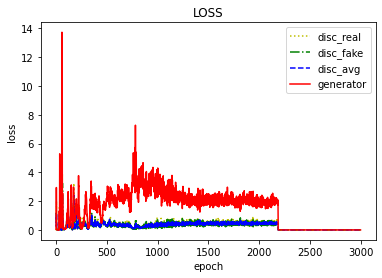

In [10]:
# 손실 그래프
import numpy as np
import matplotlib.pyplot as plt

epo = np.arange(0, epoch)

plt.figure()
plt.plot(epo, loss_disc_real,'y:',label='disc_real')
plt.plot(epo, loss_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, loss_disc_avg,'b--',label='disc_avg')
plt.plot(epo, loss_gan,'r',label='generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

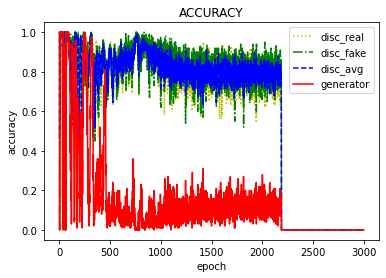

In [11]:
# 정확도 그래프
plt.figure()
plt.plot(epo, acc_disc_real,'y:',label='disc_real')
plt.plot(epo, acc_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, acc_disc_avg,'b--',label='disc_avg')
plt.plot(epo, acc_gan,'r',label='generator')
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

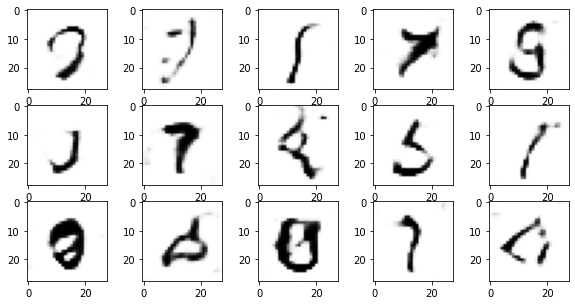

In [12]:
# epoch=3000
import matplotlib.pyplot as plt

gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize=(10, 5))

for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap='Greys')
    
plt.show()

In [13]:
loss_disc_real

[0.6216440200805664,
 0.0008533242507837713,
 0.012957623228430748,
 1.9940353631973267,
 0.003157648490741849,
 2.3846645490266383e-05,
 8.775378432801517e-07,
 7.836371906932982e-08,
 8.850916088931626e-08,
 6.525990303707374e-10,
 5.633185584663636e-10,
 3.099702161613038e-10,
 6.807938240926958e-11,
 7.161642390229872e-10,
 5.533918323585851e-10,
 1.534634780364641e-10,
 1.0854882964705936e-10,
 1.3644747658136946e-11,
 2.697657635469808e-12,
 7.192910156383903e-11,
 9.799146738487252e-08,
 4.1684217189086326e-10,
 2.7092465423872447e-11,
 6.043122113830179e-10,
 4.947569465230117e-08,
 2.0679345735796772e-10,
 1.18899185963528e-06,
 2.0311745174694806e-05,
 7.171973265940323e-05,
 0.16786913573741913,
 0.02688315324485302,
 0.507714033126831,
 0.4596790373325348,
 1.6612292528152466,
 0.015602915547788143,
 0.11722467094659805,
 0.2926537096500397,
 0.03660035505890846,
 0.0013443563366308808,
 0.0006044468027539551,
 0.0011987586040049791,
 0.009428286924958229,
 0.23484043776988

In [14]:
loss_disc_fake

[1.1255704164505005,
 1.1773638725280762,
 0.4958450198173523,
 0.3783215582370758,
 0.38563254475593567,
 0.250652551651001,
 0.1289636194705963,
 0.04743035137653351,
 0.019070547074079514,
 0.004358940292149782,
 0.0019686000887304544,
 0.0009204843663610518,
 0.0004828391538467258,
 0.003702777437865734,
 0.000888417533133179,
 0.0005964697920717299,
 0.0021018749102950096,
 0.0007836271543055773,
 0.0012467328924685717,
 0.0029818499460816383,
 0.037933994084596634,
 0.011530625633895397,
 0.012139913626015186,
 0.015504742041230202,
 0.027577459812164307,
 0.01285648811608553,
 0.04709823429584503,
 0.014918025583028793,
 0.06212268024682999,
 0.19626332819461823,
 0.24896609783172607,
 0.4867318272590637,
 0.8495140075683594,
 0.8550125360488892,
 0.20873206853866577,
 0.004204756114631891,
 0.0031698369421064854,
 0.02243744768202305,
 0.13040100038051605,
 0.1392822116613388,
 0.152310311794281,
 0.21569164097309113,
 0.47843241691589355,
 1.4701629877090454,
 1.10899245738983

In [15]:
acc_disc_real

[0.9300000071525574,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9599999785423279,
 0.9900000095367432,
 0.8799999952316284,
 0.8199999928474426,
 0.28999999165534973,
 1.0,
 0.9800000190734863,
 0.8600000143051147,
 0.9900000095367432,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9300000071525574,
 0.7300000190734863,
 0.7599999904632568,
 0.7400000095367432,
 0.9800000190734863,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7400000095367432,
 0.9200000166893005,
 0.0,
 1.0,
 0.3400000035762787,
 0.0,
 0.9599999785423279,
 0.9300000071525574,
 0.14000000059604645,
 0.6399999856948853,
 1.0,
 1.0,
 1.0,
 0.9800000190734863,
 0.949999988079071,
 0.9100000262260437,
 0.949999988079071,
 0.9700000286102295,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9900000095367432,
 1.0,
 0.9900000095367432,
 0.9800000190734863,
 1.0,
 0.9599999785423279,
 1.0,
 0.949999988079071,
 0.97000002861

In [16]:
acc_disc_fake

[0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9900000095367432,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9800000190734863,
 1.0,
 0.9900000095367432,
 1.0,
 1.0,
 1.0,
 0.9800000190734863,
 1.0,
 0.9900000095367432,
 0.8899999856948853,
 0.8899999856948853,
 0.7599999904632568,
 0.41999998688697815,
 0.33000001311302185,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9900000095367432,
 0.9599999785423279,
 0.9200000166893005,
 0.7400000095367432,
 0.3799999952316284,
 0.46000000834465027,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9700000286102295,
 0.9800000190734863,
 1.0,
 0.14000000059604645,
 1.0,
 0.0,
 0.0,
 1.0,
 0.3400000035762787,
 0.0,
 0.9599999785423279,
 1.0,
 0.9900000095367432,
 0.7300000190734863,
 0.800000011920929,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9900000095367432,
 0.9900000095367432,
 1.0,
 0.9900000095367432,
 0.9900000095367432,
 1.0,
 1.0,
 0.9900000095367432,
 1.0,
 1.0,
 0.9800000190734863,
 0.9800000190734863,
 0.9800000

# 전체 코드

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, LeakyReLU

import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(0)
tf.random.set_seed(0)

# 데이터 불러오기
(X_raw, _), (_, _) = mnist.load_data()

# 변수 설정
n_img = X_raw.shape[0]
epoch = 3000
n_batch = 100

# 데이터 전처리
X_re = X_raw.reshape(n_img, 28, 28, 1)
scale_c = 255/2
X = (X_re - scale_c) / scale_c
real_1 = np.ones((n_batch, 1))
fake_0 = np.zeros((n_batch, 1))

# 생성자
input_layer1 = Input(shape=(100,))
x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = Reshape((7,7,64))(x1)
x1 = UpSampling2D()(x1)
x1 = Conv2D(32, kernel_size=(3,3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)
output_layer1 = Conv2D(1, kernel_size=(3,3), padding='same', activation='tanh')(x1)
generator = Model(input_layer1, output_layer1)
generator.summary()

# 판별자
input_layer2 = Input(shape=(28, 28, 1))
x2 = Conv2D(64, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Conv2D(128, kernel_size=(3,3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
output_layer2 = Dense(1, activation='sigmoid')(x2)
discriminator = Model(input_layer2, output_layer2)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.trainable = False
discriminator.summary()

# GAN
input_gan = Input(shape=(100,))
output_dis = discriminator(generator(input_gan))
gan = Model(input_gan, output_dis)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gan.summary()

# 학습
loss_disc_real = [0]*epoch
loss_disc_fake = [0]*epoch
loss_disc_avg = [0]*epoch
loss_gan = [0]*epoch
acc_disc_real = [0]*epoch
acc_disc_fake = [0]*epoch
acc_disc_avg = [0]*epoch
acc_gan = [0]*epoch

for i in range(0, epoch):
    # 실제 데이터 판별
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)
    
    # 가짜 데이터 생성 및 판별
    fake = np.random.normal(0, 1, size=(n_batch, 100))
    gen_imgs = generator.predict(fake)
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0)
    
    # 판별 손실 평균 & 정확도 평균
    loss_disc_avg_ith = np.add(res_real[0],res_fake[0])*0.5
    acc_disc_avg_ith = np.add(res_real[1],res_fake[1])*0.5
    
    # GAN 결과
    res_gan = gan.train_on_batch(fake, real_1)

    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]
    loss_disc_fake[i] = res_fake[0]
    loss_disc_avg[i] = loss_disc_avg_ith
    loss_gan[i] = res_gan[0]
    
    acc_disc_real[i] = res_real[1]
    acc_disc_fake[i] = res_fake[1]
    acc_disc_avg[i] = acc_disc_avg_ith
    acc_gan[i] = res_gan[1]
    
    print('epoch:%d'%i,
          ' 판별손실평균:%.4f'%loss_disc_avg_ith,
          ' 판별정확도평균:%.4f'%acc_disc_avg_ith,
          ' 생성손실:%.4f'%res_gan[0], 
          ' 생성정확도:%.4f'%res_gan[1])

# 손실 그래프
epo = np.arange(0, epoch)

plt.figure()
plt.plot(epo, loss_disc_real,'y:',label='disc_real')
plt.plot(epo, loss_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, loss_disc_avg,'b--',label='disc_avg')
plt.plot(epo, loss_gan,'r',label='generator')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


# 정확도 그래프
plt.figure()
plt.plot(epo, acc_disc_real,'y:',label='disc_real')
plt.plot(epo, acc_disc_fake,'g-.',label='disc_fake')
plt.plot(epo, acc_disc_avg,'b--',label='disc_avg')
plt.plot(epo, acc_gan,'r',label='generator')
plt.title('ACCURACY')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


# epoch=3000
gen_imgs = 0.5 * gen_imgs + 0.5
plt.figure(figsize=(10, 5))

for i in range(3*5):
    plt.subplot(3, 5, i+1)
    plt.imshow(gen_imgs[i].reshape((28, 28)), cmap='Greys')

plt.show()